In [1]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report                # Performance accuracy, f1-score
from sklearn.metrics import roc_auc_score                        # performance en utilisant la courbe ROC et le score AUC
from sklearn.metrics import log_loss                             # Perte logarithmique
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import GridSearchCV
import tensorflow
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

# Chemins d'accès aux données
repDataConsolidees = '../../data/processed/'
repModels = '../../models/'

# Liste des fichiers usagers disponibles
!pwd
!ls {repDataConsolidees}*  -lrt
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)


2024-10-23 12:25:25.429105: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'tensorflow.keras'

### CHARGEMENT DES DONNEES

Dimension données d'apprentissage, nombre de lignes= 270717 nombre de features= 177
Dimension données de test, nombre de lignes= 90273 nombre de features= 177


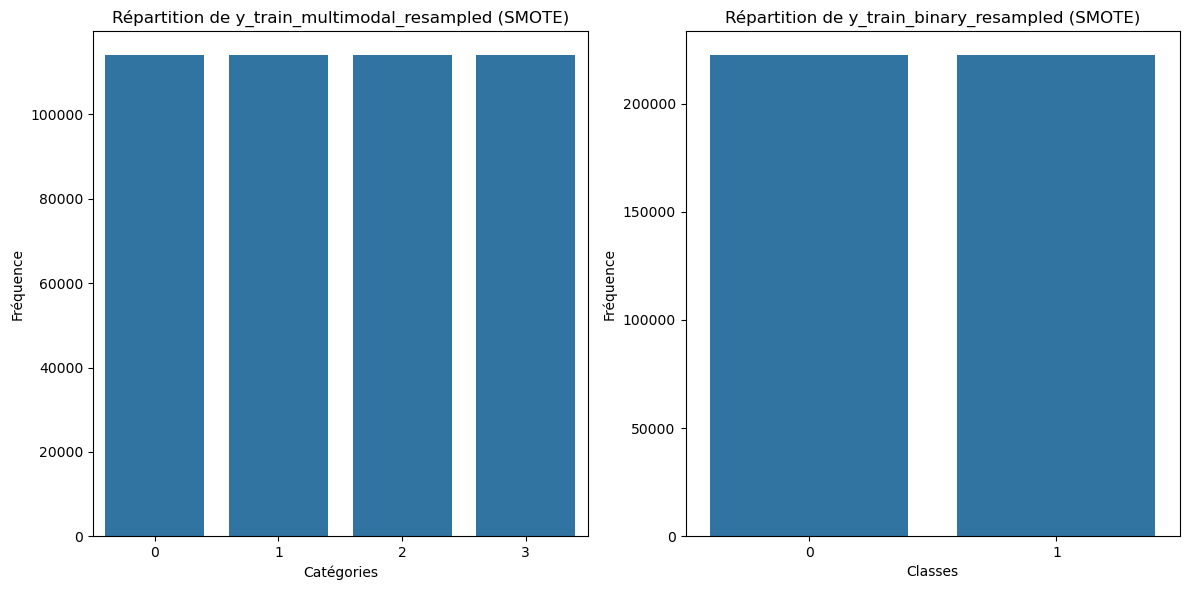

Données d'apprentissage :
- X_train_multimodal_resampled :  (456004, 177)
- X_train_binary_resampled :  (444680, 177)
- y_train_multimodal_resampled :  (456004,)
- y_train_binary_resampled :  (444680,)




In [3]:
from imblearn.over_sampling import SMOTE

# Données d'apprentissage
X_train = pd.read_csv(repDataConsolidees + 'X_train_preprocessed.csv')
y_train_multimodal = pd.read_csv(repDataConsolidees + 'y_train_preprocessed.csv')
y_train_binary = pd.read_csv(repDataConsolidees + 'y_train_binary_preprocessed.csv')

# Données de test
X_test = pd.read_csv(repDataConsolidees + 'X_test_preprocessed.csv')
y_test_multimodal = pd.read_csv(repDataConsolidees + 'y_test_preprocessed.csv')
y_test_binary = pd.read_csv(repDataConsolidees + 'y_test_binary_preprocessed.csv')

# Nombre d'inputs :
print ("Dimension données d'apprentissage, nombre de lignes=", X_train.shape[0], "nombre de features=", X_train.shape[1])
print ("Dimension données de test, nombre de lignes=", X_test.shape[0], "nombre de features=", X_test.shape[1])

# Rééquilibrage des données avec SMOTE
smote_multimodal = SMOTE(random_state=42)
smote_binary = SMOTE(random_state=42)
X_train_multimodal_resampled, y_train_multimodal_resampled = smote_multimodal.fit_resample(X_train, y_train_multimodal)
X_train_binary_resampled, y_train_binary_resampled = smote_binary.fit_resample(X_train, y_train_binary)
y_train_multimodal_resampled = y_train_multimodal_resampled['user_gravite']       # passe de df --> vecteur
y_train_binary_resampled = y_train_binary_resampled['user_gravite']

# Contrôle répartition des données multinomiale
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Diagramme pour y_train_multi
sns.countplot(x=y_train_multimodal_resampled, ax=axes[0])
axes[0].set_title('Répartition de y_train_multimodal_resampled (SMOTE)')
axes[0].set_xlabel('Catégories')
axes[0].set_ylabel('Fréquence')

# Diagramme pour y_train_binary
sns.countplot(x=y_train_binary_resampled, ax=axes[1])
axes[1].set_title('Répartition de y_train_binary_resampled (SMOTE)')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Fréquence')

# Ajuster les espacements entre les sous-graphes
plt.tight_layout()
plt.show()

print ("Données d'apprentissage :")
print ("- X_train_multimodal_resampled : ", X_train_multimodal_resampled.shape )
print ("- X_train_binary_resampled : ", X_train_binary_resampled.shape )
print ("- y_train_multimodal_resampled : ", y_train_multimodal_resampled.shape)
print ("- y_train_binary_resampled : ", y_train_binary_resampled.shape)
print ("\n")


### CALLBACK - DECLARATION DES FONCTIONS UTILISEES DANS CHAQUE RESEAU TESTE

In [4]:
# Fonction de callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Arrêt de l'apprentissage lorsque la métrique surveillée ne s'améliore plus à partir d'un certain nombre d'époque
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Sauvegarde des points afin de récupérer le modèle le plus performant
checkpoint = ModelCheckpoint('model_best.h5', monitor='val_loss', save_best_only=True)

# Ajustement du taux d'apprentissage afin d'améliorer la convergence 
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tensorflow.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)


<u>TEST 0 - REFERENCE - DNN - CLASSIFICATION MULTICLASSES - SANS REEQUILIBRAGE - METRIQUE=ACCURACY</u>

In [52]:
# ----------------------------------------------------------------------------
# TEST 0 - CLASSIFICATION MULTIMODALE - SANS REEQUILIBRAGE - METRIQUE=ACCURACY
# ----------------------------------------------------------------------------
# TEST0.1. CONSTRUCTION DU MODELE :
# ---------------------------------
# Construction d'un DNN sur la base d'une structure similaire à celle du cours 
# (Difficile de définir la structure optimale qui répondra le mieux à notre problème)
# Réseau configuré pour de la classification multimodales (maintien des 4 classes cibles)
# Ajout de couche dropout après chaque couche Dense afin d'éviter l'overfitting
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 10, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 8, activation = "tanh", name = "Dense_2")
Dropout2 = Dropout(0.2)

dense3 = Dense(units = 6, activation = "tanh", name = "Dense_3")
Dropout3 = Dropout(0.2)
dense4 = Dense(units = 4, activation = "softmax", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=Dropout2(x)
x=dense3(x)
x=Dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

# TEST 0.2 - COMPILATION DU MODELE - Classification multi classes sans rééquilibrage - fction éval=accuracy
# ---------------------------------
# S'agissant d'un problème de classification multi classes, la fonction de perte privilégiée
# sera : sparse_categorical_crossentropy
#
# 1. Maintien de la métrique accuracy pour évaluer les performances du modèle
# ------------------------
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = "adam",
              metrics=["accuracy"]
             )

# TEST 0.3 - APPRENTISSAGE DU MODELE (classification multiclasse - accuracy - SANS REEQUILIBRAGE)
# -----------------------------------
# Résultats bruts pour base de comparaison avec les 3 tests suivants

history_test0 = model.fit(X_train, y_train_multimodal, epochs=50, batch_size=32, validation_split=0.1)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test0.history['loss']
train_accuracy_history = history_test0.history['accuracy']

# Récupération des scores de validation
val_loss_history = history_test0.history.get('val_loss')
val_accuracy_history = history_test0.history.get('val_accuracy')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")






Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 159)]             0         
                                                                 
 Dense_1 (Dense)             (None, 10)                1600      
                                                                 
 dropout_6 (Dropout)         (None, 10)                0         
                                                                 
 Dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 Dense_3 (Dense)             (None, 6)                 54        
                                                                 
 dropout_8 (Dropout)         (None, 6)                 0   

In [10]:
# TEST 0.4 - EVALUATION DU MODELE (classification multiclasse - accuracy - SANS REEQUILIBRAGE)
# -------------------------------
# Résultats bruts pour base de comparaison avec les 3 tests suivants

# Evaluation des performances du modèle
from sklearn.metrics import classification_report

y_pred=model.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)

# Matrice de confusion
print(classification_report(y_test_multimodal, y_pred_class))
print(confusion_matrix(y_test_multimodal,y_pred_class))

# On constate l'effet du déséquilibre sur le modèle qui apprend correctement les classes majoritaire au détriement des autres dont la classe 3 qui nous intéresse.
#               precision    recall  f1-score   support
'''
          -1       0.00      0.00      0.00        86
           0       0.72      0.84      0.77     38039
           1       0.66      0.58      0.62     35848
           2       0.47      0.48      0.48     13946
           3       0.44      0.02      0.03      2354

    accuracy                           0.66     90273
   macro avg       0.46      0.38      0.38     90273
weighted avg       0.65      0.66      0.65     90273

[[    0    83     3     0     0]
 [    0 31992  4560  1484     3]
 [    0 10425 20908  4500    15]
 [    0  1861  5391  6658    36]
 [    0   237   641  1434    42]]
'''


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.72      0.84      0.77     38039
           1       0.66      0.58      0.62     35848
           2       0.47      0.48      0.48     13946
           3       0.44      0.02      0.03      2354

    accuracy                           0.66     90273
   macro avg       0.46      0.38      0.38     90273
weighted avg       0.65      0.66      0.65     90273

[[    0    83     3     0     0]
 [    0 31992  4560  1484     3]
 [    0 10425 20908  4500    15]
 [    0  1861  5391  6658    36]
 [    0   237   641  1434    42]]


<u>TEST 1 - CLASSIFICATION MULTICLASSES - METRIQUE=accuracy - LOSS=SPARSE_CATEGORICAL_ENTROPY - SMOTE</u>

In [8]:
# TEST 1 - Modèle pour Classification multi classes - SMOTE - accuracy, la fonction de perte privilégiée
# sera : sparse_categorical_crossentropy
#
# TEST 1.1. CONSTRUCTION DU MODELE :
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 10, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 8, activation = "tanh", name = "Dense_2")
Dropout2 = Dropout(0.2)

dense3 = Dense(units = 6, activation = "tanh", name = "Dense_3")
Dropout3 = Dropout(0.2)
dense4 = Dense(units = 4, activation = "softmax", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=Dropout2(x)
x=dense3(x)
x=Dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

# TEST 1.2. COMPILATION DU MODELE (Classification multiclasses - METRIQUE=accuracy - LOSS=SPARSE_CATEGORICAL_ENTROPY - SMOTE)
# ------------------------
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = "adam",
              metrics=["accuracy"]
             )


# TEST 1.3 - APPRENTISSAGE DU MODELE (classification multiclasse - SMOTE - accuracy)
# ----------------------------------
history_test1 = model.fit(
    X_train_multimodal_resampled, 
    y_train_multimodal_resampled, 
    validation_split=0.1,
    epochs=100, 
    batch_size=32, 
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test1.history['loss']
train_accuracy_history = history_test1.history['accuracy']

# Récupération des scores de validation
val_loss_history = history_test1.history.get('val_loss')
val_accuracy_history = history_test1.history.get('val_accuracy')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 10)                1780      
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 Dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dropout_4 (Dropout)         (None, 8)                 0         
                                                                 
 Dense_3 (Dense)             (None, 6)                 54        
                                                                 
 dropout_5 (Dropout)         (None, 6)                 0   

In [37]:
# TEST 1.4 - EVALUATION DU MODELE (classification multiclasse - accuracy - Rééquilibrage SMOTE)
# -------------------------------
from sklearn.metrics import classification_report

#y_train_pred=model.predict(X_train)
#y_train_pred_class = np.argmax(y_train_pred,axis=1)
y_train_pred=model.predict(X_train_multimodal_resampled)
y_train_pred_class = np.argmax(y_train_pred,axis=1)

# Matrice de confusion
print(classification_report(y_train_multimodal_resampled, y_train_pred_class))
print(confusion_matrix(y_train_multimodal_resampled,y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)

# Matrice de confusion
print(classification_report(y_test_multimodal, y_pred_class))
print(confusion_matrix(y_test_multimodal,y_pred_class))

'''
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.76      0.74      0.75     38039
           1       0.66      0.50      0.57     35848
           2       0.36      0.46      0.40     13946
           3       0.14      0.48      0.22      2354

    accuracy                           0.59     90273
   macro avg       0.38      0.44      0.39     90273
weighted avg       0.64      0.59      0.61     90273

[[    0    81     1     3     1]
 [    0 28122  6005  2734  1178]
 [    0  7824 17954  7730  2340]
 [    0  1065  2999  6397  3485]
 [    0   118   293   812  1131]]

'''

14251/14251 [==============================] - 27s 2ms/step
              precision    recall  f1-score   support

           0       0.25      1.00      0.40    114001
           1       0.00      0.00      0.00    114001
           2       0.00      0.00      0.00    114001
           3       0.00      0.00      0.00    114001

    accuracy                           0.25    456004
   macro avg       0.06      0.25      0.10    456004
weighted avg       0.06      0.25      0.10    456004

[[114001      0      0      0]
 [114001      0      0      0]
 [114001      0      0      0]
 [114001      0      0      0]]
2822/2822 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.42      1.00      0.59     38039
           1       0.00      0.00      0.00     35848
           2       0.00      0.00      0.00     13946
           3       0.00      0.00      0.00      235

'\n              precision    recall  f1-score   support\n\n          -1       0.00      0.00      0.00        86\n           0       0.76      0.74      0.75     38039\n           1       0.66      0.50      0.57     35848\n           2       0.36      0.46      0.40     13946\n           3       0.14      0.48      0.22      2354\n\n    accuracy                           0.59     90273\n   macro avg       0.38      0.44      0.39     90273\nweighted avg       0.64      0.59      0.61     90273\n\n[[    0    81     1     3     1]\n [    0 28122  6005  2734  1178]\n [    0  7824 17954  7730  2340]\n [    0  1065  2999  6397  3485]\n [    0   118   293   812  1131]]\n\n'

<u>TEST 2 - CLASSIFICATION MULTICLASSE - METRIQUE=F1-SCORE - LOSS=SPARSE_CATEGORIAL_ENTROPY - SMOTE</u>


In [39]:
# ------------------------------------------------------------------------------------------
# TEST 2 -  métrique f1-score avec classifivation multiclasses 
#          (loss=sparse_categorical_crossentropy) + SMOTE
# ------------------------------------------------------------------------------------------

# TEST 2.1 - CONSTRUCTION DU MODELE (Classification multiclasse - SMOTE - f1-Score)
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras import backend as K
import tensorflow as tf

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 10, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 8, activation = "tanh", name = "Dense_2")
dropout2 = Dropout(0.2)

dense3 = Dense(units = 6, activation = "tanh", name = "Dense_3")
dropout3 = Dropout(0.2)
dense4 = Dense(units = 4, activation = "softmax", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=dropout2(x)
x=dense3(x)
x=dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 2.2 - COMPILATION DU MODELE (Classification multiclasse - SMOTE - métrique f1-score
# ------------------------------
# Définition du F1-score multiclasses
def f1_score(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int32)

    # Convertir en one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
    y_pred_one_hot = tf.one_hot(y_pred, depth=tf.shape(y_pred)[-1])

    # Calcul des true positives, predicted positives et possible positives
    true_positives = tf.reduce_sum(tf.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    predicted_positives = tf.reduce_sum(tf.cast(y_pred_one_hot, 'float32'), axis=0)
    possible_positives = tf.reduce_sum(tf.cast(y_true_one_hot, 'float32'), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)  # Remplacer les NaN par des zéros

    return tf.reduce_mean(f1)  # Moyenne sur toutes les classes
    
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              #metrics=[lambda y_true, y_pred: weighted_f1_score(y_true, y_pred, class_weights)])
              metrics=[f1_score])

# TEST 2.3 - APPRENTISSAGE DU MODELE (multiclasse - SMOTE - f1-Score)
# -----------------------------------
history_test2 = model.fit(
    X_train_multimodal_resampled, 
    y_train_multimodal_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test2.history['loss']
train_accuracy_history = history_test2.history['f1_score']                   

# Si vous avez utilisé validation_data ou validation_split, vous pouvez également obtenir les scores de validation
val_loss_history = history_test2.history.get('val_loss')
val_accuracy_history = history_test2.history.get('val_f1_score')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")



Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 10)                1780      
                                                                 
 dropout_32 (Dropout)        (None, 10)                0         
                                                                 
 Dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dropout_33 (Dropout)        (None, 8)                 0         
                                                                 
 Dense_3 (Dense)             (None, 6)                 54        
                                                                 
 dropout_34 (Dropout)        (None, 6)                 0  

In [40]:
# TEST 2.4 - EVALUATION DU MODELE (multiclasse - f1-Score)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

y_train_pred=model.predict(X_train)
y_train_pred_class = np.argmax(y_train_pred,axis=1)

# Matrice de confusion
print(classification_report(y_train_multimodal, y_train_pred_class))
print(confusion_matrix(y_train_multimodal,y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)

# Matrice de confusion
print(classification_report(y_test_multimodal, y_pred_class))
print(confusion_matrix(y_test_multimodal,y_pred_class))



8460/8460 [==============================] - 15s 2ms/step
              precision    recall  f1-score   support

           0       0.73      0.81      0.76    114001
           1       0.71      0.42      0.53    108339
           2       0.36      0.53      0.43     41182
           3       0.16      0.45      0.24      7195

    accuracy                           0.60    270717
   macro avg       0.49      0.55      0.49    270717
weighted avg       0.65      0.60      0.60    270717

[[92036 10071  9132  2762]
 [30713 45413 26671  5542]
 [ 3592  7560 21678  8352]
 [  422   707  2845  3221]]
2822/2822 [==============================] - 3s 913us/step
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.73      0.81      0.77     38039
           1       0.71      0.42      0.53     35848
           2       0.36      0.53      0.43     13946
           3       0.15      0.42      0.22      2354

    accuracy 

<u>TEST 3 - CLASSIFICATION MULTICLASSE - METRIQUE=F1-SCORE PONDERE - LOSS=SPARSE_CATEGORIAL_ENTROPY - SMOTE</u>


In [26]:
# ------------------------------------------------------------------------------------------
# TEST 3 -  métrique f1-score pondéré avec classifivation multiclasses 
#          (loss=sparse_categorical_crossentropy) + SMOTE
# ------------------------------------------------------------------------------------------

# TEST 3.1 - CONSTRUCTION DU MODELE (Classification multiclasse - SMOTE - f1-Score pondéré)
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras import backend as K
import tensorflow as tf

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 10, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 8, activation = "tanh", name = "Dense_2")
dropout2 = Dropout(0.2)

dense3 = Dense(units = 6, activation = "tanh", name = "Dense_3")
dropout3 = Dropout(0.2)
dense4 = Dense(units = 4, activation = "softmax", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=dropout2(x)
x=dense3(x)
x=dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 3.2 - COMPILATION DU MODELE (Classification multiclasse - SMOTE - métrique f1-score pondéré
# ------------------------------
# Utilisation d'une factory de fonction afin de permettre le passage en paramètre de class_weights

def weighted_f1_score(y_true, y_pred, class_weights):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, 'int32')
    y_pred = K.cast(y_pred, 'int32')

    # Convertir les labels en one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, depth=len(class_weights))
    y_pred_one_hot = tf.one_hot(y_pred, depth=len(class_weights))

    # Précision et rappel pour chaque classe
    true_positives = K.sum(K.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred_one_hot, 'float32'), axis=0)
    possible_positives = K.sum(K.cast(y_true_one_hot, 'float32'), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # F1-score par classe
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Conversion des poids en float32
    class_weights = K.cast(class_weights, dtype='float32')

    # Calcul du f1-score pondéré
    weighted_f1 = K.sum(f1_scores * class_weights) / K.sum(class_weights)

    return weighted_f1


# Calcul des poids des classes
unique_classes, class_counts = np.unique(y_train_multimodal_resampled, return_counts=True)
class_weights = class_counts / len(y_train_multimodal_resampled)
class_weights = 1.0 / class_weights

# Création de la fonction weighted à partir de la factory afin de passer 2 des arguments lors de l'appel dans le compile, le 3ème (class_weights étant prés transmis via la factory
def make_weighted_f1_score(class_weights):
    def named_weighted_f1_score(y_true, y_pred):
        return weighted_f1_score(y_true, y_pred, class_weights)
    return named_weighted_f1_score

weighted_f1 = make_weighted_f1_score(class_weights)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              #metrics=[lambda y_true, y_pred: weighted_f1_score(y_true, y_pred, class_weights)])
              metrics=[weighted_f1])

# TEST 3.3 - APPRENTISSAGE DU MODELE (multiclasse - SMOTE - f1-Score pondéré)
# -----------------------------------
history_test3 = model.fit(
    X_train_multimodal_resampled, 
    y_train_multimodal_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test3.history['loss']
train_accuracy_history = history_test3.history['named_weighted_f1_score']                   # et pas weighted_f1 a cause du factory

# Si vous avez utilisé validation_data ou validation_split, vous pouvez également obtenir les scores de validation
val_loss_history = history_test3.history.get('val_loss')
val_accuracy_history = history_test3.history.get('val_named_weighted_f1_score')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")



Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 10)                1780      
                                                                 
 dropout_45 (Dropout)        (None, 10)                0         
                                                                 
 Dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dropout_46 (Dropout)        (None, 8)                 0         
                                                                 
 Dense_3 (Dense)             (None, 6)                 54        
                                                                 
 dropout_47 (Dropout)        (None, 6)                 0  

In [ ]:
# TEST 3.4 - EVALUATION DU MODELE (multiclasse - f1-Score pondéré)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

y_train_pred=model.predict(X_train)
y_train_pred_class = np.argmax(y_train_pred,axis=1)

# Matrice de confusion
print(classification_report(y_train_multimodal, y_train_pred_class))
print(confusion_matrix(y_train_multimodal,y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)

# Matrice de confusion
print(classification_report(y_test_multimodal, y_pred_class))
print(confusion_matrix(y_test_multimodal,y_pred_class))



8460/8460 [==============================] - 19s 2ms/step
              precision    recall  f1-score   support

           0       0.71      0.83      0.77    114001
           1       0.72      0.39      0.51    108339
           2       0.37      0.56      0.44     41182
           3       0.18      0.36      0.24      7195

    accuracy                           0.60    270717
   macro avg       0.49      0.54      0.49    270717
weighted avg       0.65      0.60      0.60    270717

[[94900  8284  8905  1912]
 [33975 42617 28035  3712]
 [ 4369  7224 23247  6342]
 [  535   681  3387  2592]]
2822/2822 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.71      0.83      0.77     38039
           1       0.72      0.39      0.51     35848
           2       0.37      0.57      0.45     13946
           3       0.16      0.34      0.22      2354

    accuracy   

<u>TEST 4 - CLASSIFICATION MULTICLASSE - METRIQUE=F1-SCORE - LOSS=SPARSE_CATEGORIAL_ENTROPY - SMOTE<u> 

Augmentation du nb de neurones par couche


In [41]:
# ------------------------------------------------------------------------------------------
# TEST 4 -  métrique f1-score avec classifivation multiclasses 
#          (loss=sparse_categorical_crossentropy) + SMOTE
#          Couches avec 200 - 100 - 50 - 30 - 4
# ------------------------------------------------------------------------------------------

# TEST 4.1 - CONSTRUCTION DU MODELE (Classification multiclasse - SMOTE - f1-Score)
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras import backend as K
import tensorflow as tf

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 200, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 100, activation = "tanh", name = "Dense_2")
dropout2 = Dropout(0.2)

dense3 = Dense(units = 50, activation = "tanh", name = "Dense_3")
dropout3 = Dropout(0.2)
dense4 = Dense(units = 4, activation = "softmax", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=dropout2(x)
x=dense3(x)
x=dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 4.2 - COMPILATION DU MODELE (Classification multiclasse - SMOTE - métrique f1-score pondéré
# ------------------------------
# Définition du F1-score multiclasses
def f1_score(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int32)

    # Convertir en one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
    y_pred_one_hot = tf.one_hot(y_pred, depth=tf.shape(y_pred)[-1])

    # Calcul des true positives, predicted positives et possible positives
    true_positives = tf.reduce_sum(tf.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    predicted_positives = tf.reduce_sum(tf.cast(y_pred_one_hot, 'float32'), axis=0)
    possible_positives = tf.reduce_sum(tf.cast(y_true_one_hot, 'float32'), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)  # Remplacer les NaN par des zéros

    return tf.reduce_mean(f1)  # Moyenne sur toutes les classes
    
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=[f1_score])

# TEST 4.3 - APPRENTISSAGE DU MODELE (multiclasse - SMOTE - f1-Score pondéré)
# -----------------------------------
history_test4 = model.fit(
    X_train_multimodal_resampled, 
    y_train_multimodal_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test4.history['loss']
train_accuracy_history = history_test4.history['f1_score']                   # et pas weighted_f1 a cause du factory

# Si vous avez utilisé validation_data ou validation_split, vous pouvez également obtenir les scores de validation
val_loss_history = history_test4.history.get('val_loss')
val_accuracy_history = history_test4.history.get('val_f1_score')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")



Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 200)               35600     
                                                                 
 dropout_35 (Dropout)        (None, 200)               0         
                                                                 
 Dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_36 (Dropout)        (None, 100)               0         
                                                                 
 Dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dropout_37 (Dropout)        (None, 50)                0  

In [42]:
# TEST 4.4 - EVALUATION DU MODELE (multiclasse - f1-Score)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

y_train_pred=model.predict(X_train)
y_train_pred_class = np.argmax(y_train_pred,axis=1)

# Matrice de confusion
print(classification_report(y_train_multimodal, y_train_pred_class))
print(confusion_matrix(y_train_multimodal,y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)

# Matrice de confusion
print(classification_report(y_test_multimodal, y_pred_class))
print(confusion_matrix(y_test_multimodal,y_pred_class))



8460/8460 [==============================] - 14s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.78      0.77    114001
           1       0.71      0.51      0.59    108339
           2       0.42      0.61      0.50     41182
           3       0.32      0.68      0.43      7195

    accuracy                           0.65    270717
   macro avg       0.55      0.65      0.57    270717
weighted avg       0.68      0.65      0.65    270717

[[89351 15144  8117  1389]
 [24219 55323 25060  3737]
 [ 3168  7609 25151  5254]
 [  205   330  1788  4872]]
2822/2822 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.76      0.78      0.77     38039
           1       0.69      0.50      0.58     35848
           2       0.39      0.56      0.46     13946
           3       0.17      0.36      0.23      2354

    accuracy   

<u>TEST 5 - CLASSIFICATION MULTICLASSE - METRIQUE=F1-SCORE PONDERE - LOSS=SPARSE_CATEGORIAL_ENTROPY - SMOTE<u> 
Augmentation du nb de neurones par couche



In [29]:
# ------------------------------------------------------------------------------------------
# TEST 5 -  métrique f1-score pondéré avec classifivation multiclasses 
#          (loss=sparse_categorical_crossentropy) + SMOTE
#          Couches avec 200 - 100 - 50 - 30 - 4
# ------------------------------------------------------------------------------------------

# TEST 5.1 - CONSTRUCTION DU MODELE (Classification multiclasse - SMOTE - f1-Score pondéré)
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras import backend as K
import tensorflow as tf

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 200, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 100, activation = "tanh", name = "Dense_2")
dropout2 = Dropout(0.2)

dense3 = Dense(units = 50, activation = "tanh", name = "Dense_3")
dropout3 = Dropout(0.2)
dense4 = Dense(units = 4, activation = "softmax", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=dropout2(x)
x=dense3(x)
x=dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 5.2 - COMPILATION DU MODELE (Classification multiclasse - SMOTE - métrique f1-score pondéré
# ------------------------------
# Utilisation d'une factory de fonction afin de permettre le passage en paramètre de class_weights

def weighted_f1_score(y_true, y_pred, class_weights):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, 'int32')
    y_pred = K.cast(y_pred, 'int32')

    # Convertir les labels en one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, depth=len(class_weights))
    y_pred_one_hot = tf.one_hot(y_pred, depth=len(class_weights))

    # Précision et rappel pour chaque classe
    true_positives = K.sum(K.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred_one_hot, 'float32'), axis=0)
    possible_positives = K.sum(K.cast(y_true_one_hot, 'float32'), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # F1-score par classe
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Conversion des poids en float32
    class_weights = K.cast(class_weights, dtype='float32')

    # Calcul du f1-score pondéré
    weighted_f1 = K.sum(f1_scores * class_weights) / K.sum(class_weights)

    return weighted_f1


# Calcul des poids des classes
unique_classes, class_counts = np.unique(y_train_multimodal_resampled, return_counts=True)
class_weights = class_counts / len(y_train_multimodal_resampled)
class_weights = 1.0 / class_weights

# Création de la fonction weighted à partir de la factory afin de passer 2 des arguments lors de l'appel dans le compile, le 3ème (class_weights étant prés transmis via la factory
def make_weighted_f1_score(class_weights):
    def named_weighted_f1_score(y_true, y_pred):
        return weighted_f1_score(y_true, y_pred, class_weights)
    return named_weighted_f1_score

weighted_f1 = make_weighted_f1_score(class_weights)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              #metrics=[lambda y_true, y_pred: weighted_f1_score(y_true, y_pred, class_weights)])
              metrics=[weighted_f1])

# TEST 5.3 - APPRENTISSAGE DU MODELE (multiclasse - SMOTE - f1-Score pondéré)
# -----------------------------------
history_test5 = model.fit(
    X_train_multimodal_resampled, 
    y_train_multimodal_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test5.history['loss']
train_accuracy_history = history_test5.history['named_weighted_f1_score']                   # et pas weighted_f1 a cause du factory

# Si vous avez utilisé validation_data ou validation_split, vous pouvez également obtenir les scores de validation
val_loss_history = history_test5.history.get('val_loss')
val_accuracy_history = history_test5.history.get('val_named_weighted_f1_score')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")



Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 200)               35600     
                                                                 
 dropout_51 (Dropout)        (None, 200)               0         
                                                                 
 Dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_52 (Dropout)        (None, 100)               0         
                                                                 
 Dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dropout_53 (Dropout)        (None, 50)                0  

In [31]:
# TEST 5.4 - EVALUATION DU MODELE (multiclasse - f1-Score pondéré)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

y_train_pred=model.predict(X_train)
y_train_pred_class = np.argmax(y_train_pred,axis=1)

# Matrice de confusion
print(classification_report(y_train_multimodal, y_train_pred_class))
print(confusion_matrix(y_train_multimodal,y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)

# Matrice de confusion
print(classification_report(y_test_multimodal, y_pred_class))
print(confusion_matrix(y_test_multimodal,y_pred_class))



8460/8460 [==============================] - 21s 2ms/step
              precision    recall  f1-score   support

           0       0.77      0.77      0.77    114001
           1       0.69      0.50      0.58    108339
           2       0.39      0.54      0.45     41182
           3       0.21      0.63      0.31      7195

    accuracy                           0.62    270717
   macro avg       0.51      0.61      0.53    270717
weighted avg       0.66      0.62      0.63    270717

[[87279 16697  7625  2400]
 [23077 53729 25308  6225]
 [ 3265  7137 22333  8447]
 [  269   481  1926  4519]]
2822/2822 [==============================] - 8s 3ms/step
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.76      0.76      0.76     38039
           1       0.67      0.49      0.57     35848
           2       0.38      0.52      0.44     13946
           3       0.15      0.46      0.23      2354

    accuracy   

<u>TEST 6 - CLASSIFICATION MULTICLASSE - METRIQUE=F1-SCORE - LOSS=SPARSE_CATEGORIAL_ENTROPY - SMOTE<u> 

Augmentation du nb de neurones par couche et remplacement fonction d'activation tanh par ReLu pour faire ressortir des relations non linéaires simples

In [43]:
# ------------------------------------------------------------------------------------------
# TEST 6 -  métrique f1-score avec classifivation multiclasses 
#          (loss=sparse_categorical_crossentropy) + SMOTE
#          Couches avec 200 - 100 - 50 - 30 - 4
#          FONCTION D'ACTIVATION RELU au lieu de tanh
# ------------------------------------------------------------------------------------------

# TEST 6.1 - CONSTRUCTION DU MODELE (Classification multiclasse - SMOTE - f1-Score)
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras import backend as K
import tensorflow as tf

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 200, activation = "relu", name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 100, activation = "relu", name = "Dense_2")
dropout2 = Dropout(0.2)

dense3 = Dense(units = 50, activation = "relu", name = "Dense_3")
dropout3 = Dropout(0.2)
dense4 = Dense(units = 4, activation = "softmax", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=dropout2(x)
x=dense3(x)
x=dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 6.2 - COMPILATION DU MODELE (Classification multiclasse - SMOTE - métrique f1-score pondéré
# ------------------------------
# Définition du F1-score multiclasses
def f1_score(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int32)

    # Convertir en one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
    y_pred_one_hot = tf.one_hot(y_pred, depth=tf.shape(y_pred)[-1])

    # Calcul des true positives, predicted positives et possible positives
    true_positives = tf.reduce_sum(tf.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    predicted_positives = tf.reduce_sum(tf.cast(y_pred_one_hot, 'float32'), axis=0)
    possible_positives = tf.reduce_sum(tf.cast(y_true_one_hot, 'float32'), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)  # Remplacer les NaN par des zéros

    return tf.reduce_mean(f1)  # Moyenne sur toutes les classes
    
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=[f1_score])

# TEST 6.3 - APPRENTISSAGE DU MODELE (multiclasse - SMOTE - f1-Score pondéré)
# -----------------------------------
history_test6 = model.fit(
    X_train_multimodal_resampled, 
    y_train_multimodal_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test6.history['loss']
train_accuracy_history = history_test6.history['f1_score']                   # et pas weighted_f1 a cause du factory

# Si vous avez utilisé validation_data ou validation_split, vous pouvez également obtenir les scores de validation
val_loss_history = history_test6.history.get('val_loss')
val_accuracy_history = history_test6.history.get('val_f1_score')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")



Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 200)               35600     
                                                                 
 dropout_38 (Dropout)        (None, 200)               0         
                                                                 
 Dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_39 (Dropout)        (None, 100)               0         
                                                                 
 Dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dropout_40 (Dropout)        (None, 50)                0  

In [44]:
# TEST 6.4 - EVALUATION DU MODELE (multiclasse - f1-Score)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

y_train_pred=model.predict(X_train)
y_train_pred_class = np.argmax(y_train_pred,axis=1)

# Matrice de confusion
print(classification_report(y_train_multimodal, y_train_pred_class))
print(confusion_matrix(y_train_multimodal,y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)

# Matrice de confusion
print(classification_report(y_test_multimodal, y_pred_class))
print(confusion_matrix(y_test_multimodal,y_pred_class))



8460/8460 [==============================] - 12s 1ms/step
              precision    recall  f1-score   support

           0       0.76      0.79      0.78    114001
           1       0.70      0.56      0.62    108339
           2       0.46      0.65      0.54     41182
           3       0.51      0.60      0.55      7195

    accuracy                           0.67    270717
   macro avg       0.61      0.65      0.62    270717
weighted avg       0.69      0.67      0.67    270717

[[90350 15795  7190   666]
 [24431 60183 22234  1491]
 [ 3321  9205 26754  1902]
 [  159   386  2353  4297]]
2822/2822 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.75      0.78      0.77     38039
           1       0.67      0.53      0.59     35848
           2       0.40      0.57      0.47     13946
           3       0.18      0.20      0.19      2354

    accuracy   

<u>TEST 7 - CLASSIFICATION MULTICLASSE - METRIQUE=F1-SCORE - LOSS=SPARSE_CATEGORIAL_ENTROPY - SMOTE<u> 

Augmentation du nb de neurones par couche et remplacement fonction d'activation tanh par une fonction polynomiale cubic pour faire ressortir des relations non linéaires plus complexes

In [45]:
# ------------------------------------------------------------------------------------------
# TEST 7 -  métrique f1-score avec classifivation multiclasses 
#          (loss=sparse_categorical_crossentropy) + SMOTE
#          Couches avec 200 - 100 - 50 - 30 - 4
#          FONCTION D'ACTIVATION POLYNOMIALE CUBIC au lieu de tanh
# ------------------------------------------------------------------------------------------

# TEST 7.1 - CONSTRUCTION DU MODELE (Classification multiclasse - SMOTE - f1-Score)
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras import backend as K
import tensorflow as tf

def polynomial_cubic(x):
    return tf.math.pow(x, 3)

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 200, activation = polynomial_cubic, name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 100, activation = polynomial_cubic, name = "Dense_2")
dropout2 = Dropout(0.2)

dense3 = Dense(units = 50, activation = polynomial_cubic, name = "Dense_3")
dropout3 = Dropout(0.2)
dense4 = Dense(units = 4, activation = "softmax", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=dropout2(x)
x=dense3(x)
x=dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 7.2 - COMPILATION DU MODELE (Classification multiclasse - SMOTE - métrique f1-score pondéré
# ------------------------------
# Définition du F1-score multiclasses
def f1_score(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int32)

    # Convertir en one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
    y_pred_one_hot = tf.one_hot(y_pred, depth=tf.shape(y_pred)[-1])

    # Calcul des true positives, predicted positives et possible positives
    true_positives = tf.reduce_sum(tf.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    predicted_positives = tf.reduce_sum(tf.cast(y_pred_one_hot, 'float32'), axis=0)
    possible_positives = tf.reduce_sum(tf.cast(y_true_one_hot, 'float32'), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)  # Remplacer les NaN par des zéros

    return tf.reduce_mean(f1)  # Moyenne sur toutes les classes
    
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=[f1_score])

# TEST 7.3 - APPRENTISSAGE DU MODELE (multiclasse - SMOTE - f1-Score pondéré)
# -----------------------------------
history_test7 = model.fit(
    X_train_multimodal_resampled, 
    y_train_multimodal_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test7.history['loss']
train_accuracy_history = history_test7.history['f1_score']                   # et pas weighted_f1 a cause du factory

# Si vous avez utilisé validation_data ou validation_split, vous pouvez également obtenir les scores de validation
val_loss_history = history_test7.history.get('val_loss')
val_accuracy_history = history_test7.history.get('val_f1_score')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")



Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 200)               35600     
                                                                 
 dropout_41 (Dropout)        (None, 200)               0         
                                                                 
 Dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_42 (Dropout)        (None, 100)               0         
                                                                 
 Dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dropout_43 (Dropout)        (None, 50)                0  

In [46]:
# TEST 7.4 - EVALUATION DU MODELE (multiclasse - f1-Score)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

y_train_pred=model.predict(X_train)
y_train_pred_class = np.argmax(y_train_pred,axis=1)

# Matrice de confusion
print(classification_report(y_train_multimodal, y_train_pred_class))
print(confusion_matrix(y_train_multimodal,y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = np.argmax(y_pred,axis=1)

# Matrice de confusion
print(classification_report(y_test_multimodal, y_pred_class))
print(confusion_matrix(y_test_multimodal,y_pred_class))



8460/8460 [==============================] - 13s 2ms/step
              precision    recall  f1-score   support

           0       0.74      0.79      0.77    114001
           1       0.70      0.44      0.54    108339
           2       0.38      0.51      0.44     41182
           3       0.21      0.73      0.33      7195

    accuracy                           0.61    270717
   macro avg       0.51      0.62      0.52    270717
weighted avg       0.66      0.61      0.61    270717

[[90462 12770  8203  2566]
 [28138 47689 25268  7244]
 [ 3251  7017 21156  9758]
 [  191   297  1441  5266]]
2822/2822 [==============================] - 4s 1ms/step
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        86
           0       0.74      0.79      0.76     38039
           1       0.68      0.43      0.53     35848
           2       0.35      0.48      0.41     13946
           3       0.13      0.46      0.20      2354

    accuracy   

<u>TEST 8 - CLASSIFICATION BINAIRE - METRIQUE=F1-SCORE - LOSS=BINARY_CROSSENTROPY - SMOTE</u>

In [71]:
# ------------------------------------------------------------------------------------------
# TEST 8 -  métrique f1-score avec classifivation binaire (loss=binary_crossentropy) + SMOTE
# ------------------------------------------------------------------------------------------
# Le f1-score est une métrique plutôt utilisé pour des problèmes de classification binaire
# la métrique f1-score ne semble pas prise en charge par la fonction "compile" de keras 
# --> Obligation de passer par une fonction d'évaluation personnalisée :  ici f1_score_metric

# 1. Construction d'un DNN sur la base d'une structure similaire à celle du cours (Difficile de définir la structure optimale qui répondra le mieux à notre problème : on réutilise le travail des autres)
# Réseau configuré pour de la classification multimodales (maintien des 4 classes cibles)
# Ajout de couche dropout après chaque couche Dense afin d'éviter l'overfitting

# TEST 8.1 - Construction du modèle
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 10, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.4)

dense2 = Dense(units = 8, activation = "tanh", name = "Dense_2")
Dropout2 = Dropout(0.4)

dense3 = Dense(units = 4, activation = "tanh", name = "Dense_3")
Dropout3 = Dropout(0.4)
dense4 = Dense(units = 1, activation = "sigmoid", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=Dropout2(x)
x=dense3(x)
#x=Dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 8.2 - COMPILATION DU MODELE (classification binaire - SMOTE - f1-score)
# --------------------------------
def f1_score_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

# A privilégier pour la classification binaire
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f1_score_metric])


# TEST 8.3 - APPRENTISSAGE DU MODELE - classification binaire - f1-Score - SMOTE
# ----------------------------------
history_test8 = model.fit(
    X_train_binary_resampled, 
    y_train_binary_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test8.history['loss']
train_accuracy_history = history_test8.history['f1_score_metric']

# Récupération des scores de validation
val_loss_history = history_test8.history.get('val_loss')
val_accuracy_history = history_test8.history.get('val_f1_score_metric')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")

# Sauvegarde du modèle (il sera utilisé pour la partie interprétabilité)
model.save(repModels + 'DNNmodel_10_8_4.h5')



Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 10)                1780      
                                                                 
 dropout_75 (Dropout)        (None, 10)                0         
                                                                 
 Dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dropout_76 (Dropout)        (None, 8)                 0         
                                                                 
 Dense_3 (Dense)             (None, 4)                 36        
                                                                 
 Dense_4 (Dense)             (None, 1)                 5  

In [49]:
# TEST 8.4 - EVALUATION DU MODELE - classification binaire - f1-Score - SMOTE
# -----------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

# EVALUATION DU MODELE sur échantillon train
y_train_pred=model.predict(X_train)
threshold = 0.5
y_train_pred_class = (y_train_pred >= threshold).astype(int)

# Matrice de confusion
print(classification_report(y_train_binary, y_train_pred_class))
print(confusion_matrix(y_train_binary, y_train_pred_class))


# EVALUATION DU MODELE sur échantillon test
y_pred=model.predict(X_test)
threshold = 0.5
y_pred_class = (y_pred >= threshold).astype(int)

# Matrice de confusion
print(classification_report(y_test_binary, y_pred_class))
print(confusion_matrix(y_test_binary,y_pred_class))



8460/8460 [==============================] - 12s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.78      0.85    222340
           1       0.43      0.76      0.55     48377

    accuracy                           0.78    270717
   macro avg       0.68      0.77      0.70    270717
weighted avg       0.85      0.78      0.80    270717

[[174080  48260]
 [ 11766  36611]]
2822/2822 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.78      0.85     73973
           1       0.43      0.75      0.55     16300

    accuracy                           0.78     90273
   macro avg       0.68      0.77      0.70     90273
weighted avg       0.84      0.78      0.80     90273

[[57890 16083]
 [ 4018 12282]]


<u>TEST 9 - CLASSIFICATION BINAIRE - METRIQUE=F1-SCORE pondéré - LOSS=BINARY_CROSSENTROPY - SMOTE</u>

In [51]:
# ------------------------------------------------------------------------------------------
# TEST 9 -  métrique f1-score avec classifivation binaire (loss=binary_crossentropy) + SMOTE
# ------------------------------------------------------------------------------------------
# Remplacement fonction d'activation tanh par reLu pour rechercher des relation non linéaires simples
# TEST 9.1 - Construction du modèle
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 10, activation = "relu", name = "Dense_1")
dropout1 = Dropout(0.4)

dense2 = Dense(units = 8, activation = "relu", name = "Dense_2")
Dropout2 = Dropout(0.4)

dense3 = Dense(units = 4, activation = "relu", name = "Dense_3")
Dropout3 = Dropout(0.4)
dense4 = Dense(units = 1, activation = "sigmoid", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=Dropout2(x)
x=dense3(x)
#x=Dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 9.2 - COMPILATION DU MODELE (classification binaire - SMOTE - f1-score)
# --------------------------------
def f1_score_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

# A privilégier pour la classification binaire
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f1_score_metric])


# TEST 9.3 - APPRENTISSAGE DU MODELE - classification binaire - f1-Score - SMOTE
# ----------------------------------
history_test9 = model.fit(
    X_train_binary_resampled, 
    y_train_binary_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test9.history['loss']
train_accuracy_history = history_test9.history['f1_score_metric']

# Récupération des scores de validation
val_loss_history = history_test9.history.get('val_loss')
val_accuracy_history = history_test9.history.get('val_f1_score_metric')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")

# Sauvegarde du modèle (il sera utilisé pour la partie interprétabilité)
model.save(repModels + 'DNNmodel_10_8_4_test9.h5')



Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 10)                1780      
                                                                 
 dropout_50 (Dropout)        (None, 10)                0         
                                                                 
 Dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dropout_51 (Dropout)        (None, 8)                 0         
                                                                 
 Dense_3 (Dense)             (None, 4)                 36        
                                                                 
 Dense_4 (Dense)             (None, 1)                 5  

In [52]:
# TEST 9.4 - EVALUATION DU MODELE - classification binaire - f1-Score - SMOTE - activation=RELU
# -----------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

# EVALUATION DU MODELE sur échantillon train
y_train_pred=model.predict(X_train)
threshold = 0.5
y_train_pred_class = (y_train_pred >= threshold).astype(int)

# Matrice de confusion
print(classification_report(y_train_binary, y_train_pred_class))
print(confusion_matrix(y_train_binary, y_train_pred_class))


# EVALUATION DU MODELE sur échantillon test
y_pred=model.predict(X_test)
threshold = 0.5
y_pred_class = (y_pred >= threshold).astype(int)

# Matrice de confusion
print(classification_report(y_test_binary, y_pred_class))
print(confusion_matrix(y_test_binary,y_pred_class))



8460/8460 [==============================] - 19s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.79      0.86    222340
           1       0.45      0.77      0.57     48377

    accuracy                           0.79    270717
   macro avg       0.69      0.78      0.71    270717
weighted avg       0.85      0.79      0.81    270717

[[175777  46563]
 [ 10918  37459]]
2822/2822 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     73973
           1       0.44      0.77      0.56     16300

    accuracy                           0.78     90273
   macro avg       0.69      0.78      0.71     90273
weighted avg       0.85      0.78      0.80     90273

[[58225 15748]
 [ 3777 12523]]


<u>TEST 10 - CLASSIFICATION BINAIRE - METRIQUE=F1-SCORE pondéré - LOSS=BINARY_CROSSENTROPY - SMOTE</u>
activation=tanh


In [53]:
# ------------------------------------------------------------------------------------------
# TEST 10 -  métrique f1-score pondéré avec classifivation binaire 
#          (loss=sparse_categorical_crossentropy) + SMOTE
#          Couches avec 10 - 8 - 4 - 1
# ------------------------------------------------------------------------------------------

# TEST 10.1 - CONSTRUCTION DU MODELE (Classification binaire - SMOTE - f1-Score pondéré)
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras import backend as K
import tensorflow as tf

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 10, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 8, activation = "tanh", name = "Dense_2")
dropout2 = Dropout(0.2)

dense3 = Dense(units = 4, activation = "tanh", name = "Dense_3")
dropout3 = Dropout(0.2)
dense4 = Dense(units = 1, activation = "sigmoid", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=dropout2(x)
x=dense3(x)
#x=dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 10.2 - COMPILATION DU MODELE (Classification multiclasse - SMOTE - métrique f1-score pondéré
# ------------------------------
# Utilisation d'une factory de fonction afin de permettre le passage en paramètre de class_weights
def weighted_f1_score(y_true, y_pred, class_weights):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, 'int32')
    y_pred = K.cast(y_pred, 'int32')

    # Convertir les labels en one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, depth=len(class_weights))
    y_pred_one_hot = tf.one_hot(y_pred, depth=len(class_weights))

    # Précision et rappel pour chaque classe
    true_positives = K.sum(K.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred_one_hot, 'float32'), axis=0)
    possible_positives = K.sum(K.cast(y_true_one_hot, 'float32'), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # F1-score par classe
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Conversion des poids en float32
    class_weights = K.cast(class_weights, dtype='float32')

    # Calcul du f1-score pondéré
    weighted_f1 = K.sum(f1_scores * class_weights) / K.sum(class_weights)

    return weighted_f1


# Calcul des poids des classes
unique_classes, class_counts = np.unique(y_train_binary_resampled, return_counts=True)
class_weights = class_counts / len(y_train_binary_resampled)
class_weights = 1.0 / class_weights

# Création de la fonction weighted à partir de la factory afin de passer 2 des arguments lors de l'appel dans le compile, le 3ème (class_weights étant prés transmis via la factory
def make_weighted_f1_score(class_weights):
    def named_weighted_f1_score(y_true, y_pred):
        return weighted_f1_score(y_true, y_pred, class_weights)
    return named_weighted_f1_score

weighted_f1 = make_weighted_f1_score(class_weights)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[weighted_f1])
              #metrics=[f1_score_metric])  

# TEST 10.3 - APPRENTISSAGE DU MODELE (multiclasse - SMOTE - f1-Score pondéré)
# -----------------------------------
history_test10 = model.fit(
    X_train_binary_resampled, 
    y_train_binary_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test10.history['loss']
train_accuracy_history = history_test10.history['named_weighted_f1_score']                   # et pas weighted_f1 a cause du factory
#train_accuracy_history = history_test5.history['f1_score_metric']                   # et pas weighted_f1 a cause du factory

# Si vous avez utilisé validation_data ou validation_split, vous pouvez également obtenir les scores de validation
val_loss_history = history_test10.history.get('val_loss')
val_accuracy_history = history_test10.history.get('val_named_weighted_f1_score')
#val_accuracy_history = history_test5.history.get('val_f1_score_metric')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")



Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 10)                1780      
                                                                 
 dropout_53 (Dropout)        (None, 10)                0         
                                                                 
 Dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dropout_54 (Dropout)        (None, 8)                 0         
                                                                 
 Dense_3 (Dense)             (None, 4)                 36        
                                                                 
 Dense_4 (Dense)             (None, 1)                 5  

In [54]:
# TEST 10.4 - EVALUATION DU MODELE (binary - f1-Score pondéré - activation=tanh)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

threshold = 0.5
y_train_pred=model.predict(X_train)
y_train_pred_class = (y_train_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_train_binary, y_train_pred_class))
print(confusion_matrix(y_train_binary, y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = (y_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_test_binary, y_pred_class))
print(confusion_matrix(y_test_binary,y_pred_class))

# 0.77 - 0.28


8460/8460 [==============================] - 18s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.76      0.84    222340
           1       0.41      0.79      0.54     48377

    accuracy                           0.76    270717
   macro avg       0.68      0.77      0.69    270717
weighted avg       0.85      0.76      0.79    270717

[[167970  54370]
 [ 10116  38261]]
2822/2822 [==============================] - 6s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.75      0.84     73973
           1       0.42      0.79      0.54     16300

    accuracy                           0.76     90273
   macro avg       0.68      0.77      0.69     90273
weighted avg       0.85      0.76      0.79     90273

[[55835 18138]
 [ 3413 12887]]


<u>TEST 11 - CLASSIFICATION BINAIRE - METRIQUE=F1-SCORE pondéré - LOSS=BINARY_CROSSENTROPY - SMOTE</u>
activation=relu

In [55]:
# ------------------------------------------------------------------------------------------
# TEST 11 -  métrique f1-score pondéré avec classifivation binaire 
#          (loss=sparse_categorical_crossentropy) + SMOTE
#          Couches avec 10 - 8 - 4 - 1
# ------------------------------------------------------------------------------------------

# TEST 10.1 - CONSTRUCTION DU MODELE (Classification binaire - SMOTE - f1-Score pondéré)
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras import backend as K
import tensorflow as tf

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 10, activation = "relu", name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 8, activation = "relu", name = "Dense_2")
dropout2 = Dropout(0.2)

dense3 = Dense(units = 4, activation = "relu", name = "Dense_3")
dropout3 = Dropout(0.2)
dense4 = Dense(units = 1, activation = "sigmoid", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=dropout2(x)
x=dense3(x)
#x=dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 11.2 - COMPILATION DU MODELE (Classification multiclasse - SMOTE - métrique f1-score pondéré
# ------------------------------
# Utilisation d'une factory de fonction afin de permettre le passage en paramètre de class_weights
def weighted_f1_score(y_true, y_pred, class_weights):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, 'int32')
    y_pred = K.cast(y_pred, 'int32')

    # Convertir les labels en one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, depth=len(class_weights))
    y_pred_one_hot = tf.one_hot(y_pred, depth=len(class_weights))

    # Précision et rappel pour chaque classe
    true_positives = K.sum(K.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred_one_hot, 'float32'), axis=0)
    possible_positives = K.sum(K.cast(y_true_one_hot, 'float32'), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # F1-score par classe
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Conversion des poids en float32
    class_weights = K.cast(class_weights, dtype='float32')

    # Calcul du f1-score pondéré
    weighted_f1 = K.sum(f1_scores * class_weights) / K.sum(class_weights)

    return weighted_f1


# Calcul des poids des classes
unique_classes, class_counts = np.unique(y_train_binary_resampled, return_counts=True)
class_weights = class_counts / len(y_train_binary_resampled)
class_weights = 1.0 / class_weights

# Création de la fonction weighted à partir de la factory afin de passer 2 des arguments lors de l'appel dans le compile, le 3ème (class_weights étant prés transmis via la factory
def make_weighted_f1_score(class_weights):
    def named_weighted_f1_score(y_true, y_pred):
        return weighted_f1_score(y_true, y_pred, class_weights)
    return named_weighted_f1_score

weighted_f1 = make_weighted_f1_score(class_weights)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[weighted_f1])
              #metrics=[f1_score_metric])  

# TEST 11.3 - APPRENTISSAGE DU MODELE (multiclasse - SMOTE - f1-Score pondéré)
# -----------------------------------
history_test11 = model.fit(
    X_train_binary_resampled, 
    y_train_binary_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test11.history['loss']
train_accuracy_history = history_test11.history['named_weighted_f1_score']                   # et pas weighted_f1 a cause du factory
#train_accuracy_history = history_test5.history['f1_score_metric']                   # et pas weighted_f1 a cause du factory

# Si vous avez utilisé validation_data ou validation_split, vous pouvez également obtenir les scores de validation
val_loss_history = history_test11.history.get('val_loss')
val_accuracy_history = history_test11.history.get('val_named_weighted_f1_score')
#val_accuracy_history = history_test5.history.get('val_f1_score_metric')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")



Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 10)                1780      
                                                                 
 dropout_56 (Dropout)        (None, 10)                0         
                                                                 
 Dense_2 (Dense)             (None, 8)                 88        
                                                                 
 dropout_57 (Dropout)        (None, 8)                 0         
                                                                 
 Dense_3 (Dense)             (None, 4)                 36        
                                                                 
 Dense_4 (Dense)             (None, 1)                 5  

In [56]:
# TEST 11.4 - EVALUATION DU MODELE (binary - f1-Score pondéré - activation=relu)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

threshold = 0.5
y_train_pred=model.predict(X_train)
y_train_pred_class = (y_train_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_train_binary, y_train_pred_class))
print(confusion_matrix(y_train_binary, y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = (y_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_test_binary, y_pred_class))
print(confusion_matrix(y_test_binary,y_pred_class))

# 0.77 - 0.28


8460/8460 [==============================] - 13s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.79      0.86    222340
           1       0.45      0.78      0.57     48377

    accuracy                           0.79    270717
   macro avg       0.69      0.79      0.71    270717
weighted avg       0.85      0.79      0.81    270717

[[175394  46946]
 [ 10547  37830]]
2822/2822 [==============================] - 4s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     73973
           1       0.44      0.77      0.56     16300

    accuracy                           0.78     90273
   macro avg       0.69      0.78      0.71     90273
weighted avg       0.85      0.78      0.80     90273

[[58177 15796]
 [ 3695 12605]]


<u>TEST 12 - CLASSIFICATION BINAIRE - METRIQUE=F1-SCORE - LOSS=BINARY_CROSSENTROPY - SMOTE</u>
activation=tanh
réseaux avec plus de neurones

In [57]:
# ------------------------------------------------------------------------------------------
# TEST 12 -  métrique f1-score avec classifivation binaire (loss=binary_crossentropy) + SMOTE
# ------------------------------------------------------------------------------------------
# Augmentation du nombre de neurones (200 - 100 - 50 - 1)

# TEST 12.1 - Construction du modèle
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 200, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.4)

dense2 = Dense(units = 100, activation = "tanh", name = "Dense_2")
Dropout2 = Dropout(0.4)

dense3 = Dense(units = 50, activation = "tanh", name = "Dense_3")
Dropout3 = Dropout(0.4)
dense4 = Dense(units = 1, activation = "sigmoid", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=Dropout2(x)
x=dense3(x)
#x=Dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 12.2 - COMPILATION DU MODELE (classification binaire - SMOTE - f1-score)
# --------------------------------
def f1_score_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

# A privilégier pour la classification binaire
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f1_score_metric])


# TEST 12.3 - APPRENTISSAGE DU MODELE - classification binaire - f1-Score - SMOTE
# ----------------------------------
history_test12 = model.fit(
    X_train_binary_resampled, 
    y_train_binary_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test12.history['loss']
train_accuracy_history = history_test12.history['f1_score_metric']

# Récupération des scores de validation
val_loss_history = history_test12.history.get('val_loss')
val_accuracy_history = history_test12.history.get('val_f1_score_metric')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")

# Sauvegarde du modèle (il sera utilisé pour la partie interprétabilité)
model.save(repModels + 'DNNmodel_150_80_40.h5')
#model.save(repModels + 'DNNmodel_10_8_6.h5')



Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 200)               35600     
                                                                 
 dropout_59 (Dropout)        (None, 200)               0         
                                                                 
 Dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_60 (Dropout)        (None, 100)               0         
                                                                 
 Dense_3 (Dense)             (None, 50)                5050      
                                                                 
 Dense_4 (Dense)             (None, 1)                 51 

In [58]:
# TEST 12.4 - EVALUATION DU MODELE (binary - f1-Score - activation=tanh)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

threshold = 0.5
y_train_pred=model.predict(X_train)
y_train_pred_class = (y_train_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_train_binary, y_train_pred_class))
print(confusion_matrix(y_train_binary, y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = (y_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_test_binary, y_pred_class))
print(confusion_matrix(y_test_binary,y_pred_class))

# 0.77 - 0.28


8460/8460 [==============================] - 13s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.78      0.85    222340
           1       0.44      0.79      0.56     48377

    accuracy                           0.78    270717
   macro avg       0.69      0.79      0.71    270717
weighted avg       0.85      0.78      0.80    270717

[[173141  49199]
 [  9960  38417]]
2822/2822 [==============================] - 8s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.78      0.85     73973
           1       0.44      0.79      0.56     16300

    accuracy                           0.78     90273
   macro avg       0.69      0.78      0.71     90273
weighted avg       0.85      0.78      0.80     90273

[[57535 16438]
 [ 3428 12872]]


<u>TEST 13 - CLASSIFICATION BINAIRE - METRIQUE=F1-SCORE - LOSS=BINARY_CROSSENTROPY - SMOTE</u>
activation=relu
réseaux avec plus de neurones

In [59]:
# ------------------------------------------------------------------------------------------
# TEST 13 -  métrique f1-score avec classifivation binaire (loss=binary_crossentropy) + SMOTE
# ------------------------------------------------------------------------------------------
#          reseau dense (200 - 100 - 50 - 1)
#          activation=reLu (rechercher des relation non linéaires simples)
#          metric=f1-score 

# TEST 13.1 - Construction du modèle
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 200, activation = "relu", name = "Dense_1")
dropout1 = Dropout(0.4)

dense2 = Dense(units = 100, activation = "relu", name = "Dense_2")
Dropout2 = Dropout(0.4)

dense3 = Dense(units = 50, activation = "relu", name = "Dense_3")
Dropout3 = Dropout(0.4)
dense4 = Dense(units = 1, activation = "sigmoid", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=Dropout2(x)
x=dense3(x)
#x=Dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 13.2 - COMPILATION DU MODELE (classification binaire - SMOTE - f1-score)
# --------------------------------
def f1_score_metric(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

# A privilégier pour la classification binaire
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f1_score_metric])


# TEST 13.3 - APPRENTISSAGE DU MODELE - classification binaire - f1-Score - SMOTE
# ----------------------------------
history_test13 = model.fit(
    X_train_binary_resampled, 
    y_train_binary_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test13.history['loss']
train_accuracy_history = history_test13.history['f1_score_metric']

# Récupération des scores de validation
val_loss_history = history_test13.history.get('val_loss')
val_accuracy_history = history_test13.history.get('val_f1_score_metric')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")

# Sauvegarde du modèle (il sera utilisé pour la partie interprétabilité)
model.save(repModels + 'DNNmodel_150_80_40.h5')
#model.save(repModels + 'DNNmodel_10_8_6.h5')



Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 200)               35600     
                                                                 
 dropout_62 (Dropout)        (None, 200)               0         
                                                                 
 Dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_63 (Dropout)        (None, 100)               0         
                                                                 
 Dense_3 (Dense)             (None, 50)                5050      
                                                                 
 Dense_4 (Dense)             (None, 1)                 51 

In [60]:
# TEST 13.4 - EVALUATION DU MODELE (binary - f1-Score - activation=relu)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

threshold = 0.5
y_train_pred=model.predict(X_train)
y_train_pred_class = (y_train_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_train_binary, y_train_pred_class))
print(confusion_matrix(y_train_binary, y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = (y_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_test_binary, y_pred_class))
print(confusion_matrix(y_test_binary,y_pred_class))

# 0.77 - 0.28


8460/8460 [==============================] - 14s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.82      0.88    222340
           1       0.50      0.82      0.62     48377

    accuracy                           0.82    270717
   macro avg       0.73      0.82      0.75    270717
weighted avg       0.87      0.82      0.83    270717

[[182395  39945]
 [  8841  39536]]
2822/2822 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     73973
           1       0.45      0.73      0.56     16300

    accuracy                           0.79     90273
   macro avg       0.69      0.77      0.71     90273
weighted avg       0.84      0.79      0.81     90273

[[59411 14562]
 [ 4413 11887]]


<u>TEST 14 - CLASSIFICATION BINAIRE - METRIQUE=F1-SCORE PONDERE - LOSS=BINARY_CROSSENTROPY - SMOTE</u>
activation=tanh
réseaux avec plus de neurones

In [61]:
# ------------------------------------------------------------------------------------------
# TEST 14 -  métrique f1-score pondéré avec classifivation binaire 
#          (loss=sparse_categorical_crossentropy) + SMOTE
#          Couches avec 200 - 100 - 50 - 1
#          activation=tanh
#          metric=f1-score pondéré
# ------------------------------------------------------------------------------------------

# TEST 10.1 - CONSTRUCTION DU MODELE (Classification binaire - SMOTE - f1-Score pondéré)
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras import backend as K
import tensorflow as tf

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 200, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 100, activation = "tanh", name = "Dense_2")
dropout2 = Dropout(0.2)

dense3 = Dense(units = 50, activation = "tanh", name = "Dense_3")
dropout3 = Dropout(0.2)
dense4 = Dense(units = 1, activation = "sigmoid", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=dropout2(x)
x=dense3(x)
#x=dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 14.2 - COMPILATION DU MODELE (Classification multiclasse - SMOTE - métrique f1-score pondéré
# ------------------------------
# Utilisation d'une factory de fonction afin de permettre le passage en paramètre de class_weights
def weighted_f1_score(y_true, y_pred, class_weights):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, 'int32')
    y_pred = K.cast(y_pred, 'int32')

    # Convertir les labels en one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, depth=len(class_weights))
    y_pred_one_hot = tf.one_hot(y_pred, depth=len(class_weights))

    # Précision et rappel pour chaque classe
    true_positives = K.sum(K.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred_one_hot, 'float32'), axis=0)
    possible_positives = K.sum(K.cast(y_true_one_hot, 'float32'), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # F1-score par classe
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Conversion des poids en float32
    class_weights = K.cast(class_weights, dtype='float32')

    # Calcul du f1-score pondéré
    weighted_f1 = K.sum(f1_scores * class_weights) / K.sum(class_weights)

    return weighted_f1


# Calcul des poids des classes
unique_classes, class_counts = np.unique(y_train_binary_resampled, return_counts=True)
class_weights = class_counts / len(y_train_binary_resampled)
class_weights = 1.0 / class_weights

# Création de la fonction weighted à partir de la factory afin de passer 2 des arguments lors de l'appel dans le compile, le 3ème (class_weights étant prés transmis via la factory
def make_weighted_f1_score(class_weights):
    def named_weighted_f1_score(y_true, y_pred):
        return weighted_f1_score(y_true, y_pred, class_weights)
    return named_weighted_f1_score

weighted_f1 = make_weighted_f1_score(class_weights)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[weighted_f1])
              #metrics=[f1_score_metric])  

# TEST 14.3 - APPRENTISSAGE DU MODELE (multiclasse - SMOTE - f1-Score pondéré)
# -----------------------------------
history_test14 = model.fit(
    X_train_binary_resampled, 
    y_train_binary_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test14.history['loss']
train_accuracy_history = history_test14.history['named_weighted_f1_score']                   # et pas weighted_f1 a cause du factory
#train_accuracy_history = history_test5.history['f1_score_metric']                   # et pas weighted_f1 a cause du factory

# Si vous avez utilisé validation_data ou validation_split, vous pouvez également obtenir les scores de validation
val_loss_history = history_test14.history.get('val_loss')
val_accuracy_history = history_test14.history.get('val_named_weighted_f1_score')
#val_accuracy_history = history_test5.history.get('val_f1_score_metric')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")



Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 200)               35600     
                                                                 
 dropout_65 (Dropout)        (None, 200)               0         
                                                                 
 Dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_66 (Dropout)        (None, 100)               0         
                                                                 
 Dense_3 (Dense)             (None, 50)                5050      
                                                                 
 Dense_4 (Dense)             (None, 1)                 51 

In [62]:
# TEST 14.4 - EVALUATION DU MODELE (binary - f1-Score pondéré - activation=tanh)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

threshold = 0.5
y_train_pred=model.predict(X_train)
y_train_pred_class = (y_train_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_train_binary, y_train_pred_class))
print(confusion_matrix(y_train_binary, y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = (y_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_test_binary, y_pred_class))
print(confusion_matrix(y_test_binary,y_pred_class))

# 0.77 - 0.28


8460/8460 [==============================] - 19s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.80      0.87    222340
           1       0.46      0.81      0.59     48377

    accuracy                           0.80    270717
   macro avg       0.71      0.80      0.73    270717
weighted avg       0.86      0.80      0.82    270717

[[177197  45143]
 [  9156  39221]]
2822/2822 [==============================] - 5s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     73973
           1       0.45      0.77      0.57     16300

    accuracy                           0.79     90273
   macro avg       0.69      0.78      0.71     90273
weighted avg       0.85      0.79      0.80     90273

[[58267 15706]
 [ 3695 12605]]


<u>TEST 15 - CLASSIFICATION BINAIRE - METRIQUE=F1-SCORE PONDERE - LOSS=BINARY_CROSSENTROPY - SMOTE</u>
activation=relu
réseaux avec plus de neurones

In [63]:
# ------------------------------------------------------------------------------------------
# TEST 15 -  métrique f1-score pondéré avec classifivation binaire 
#          (loss=sparse_categorical_crossentropy) + SMOTE
#          Couches avec 200 - 100 - 50 - 1
#          activation=relu
#          métric=f1-score pondéré
# ------------------------------------------------------------------------------------------

# TEST 15.1 - CONSTRUCTION DU MODELE (Classification binaire - SMOTE - f1-Score pondéré)
# ---------------------------------
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from keras import backend as K
import tensorflow as tf

inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 200, activation = "relu", name = "Dense_1")
dropout1 = Dropout(0.2)

dense2 = Dense(units = 100, activation = "relu", name = "Dense_2")
dropout2 = Dropout(0.2)

dense3 = Dense(units = 50, activation = "relu", name = "Dense_3")
dropout3 = Dropout(0.2)
dense4 = Dense(units = 1, activation = "sigmoid", name = "Dense_4")

# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=dropout2(x)
x=dense3(x)
#x=dropout3(x)
outputs=dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()


# TEST 15.2 - COMPILATION DU MODELE (Classification multiclasse - SMOTE - métrique f1-score pondéré
# ------------------------------
# Utilisation d'une factory de fonction afin de permettre le passage en paramètre de class_weights
def weighted_f1_score(y_true, y_pred, class_weights):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = K.cast(y_true, 'int32')
    y_pred = K.cast(y_pred, 'int32')

    # Convertir les labels en one-hot encoding
    y_true_one_hot = tf.one_hot(y_true, depth=len(class_weights))
    y_pred_one_hot = tf.one_hot(y_pred, depth=len(class_weights))

    # Précision et rappel pour chaque classe
    true_positives = K.sum(K.cast(y_true_one_hot * y_pred_one_hot, 'float32'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred_one_hot, 'float32'), axis=0)
    possible_positives = K.sum(K.cast(y_true_one_hot, 'float32'), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # F1-score par classe
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Conversion des poids en float32
    class_weights = K.cast(class_weights, dtype='float32')

    # Calcul du f1-score pondéré
    weighted_f1 = K.sum(f1_scores * class_weights) / K.sum(class_weights)

    return weighted_f1


# Calcul des poids des classes
unique_classes, class_counts = np.unique(y_train_binary_resampled, return_counts=True)
class_weights = class_counts / len(y_train_binary_resampled)
class_weights = 1.0 / class_weights

# Création de la fonction weighted à partir de la factory afin de passer 2 des arguments lors de l'appel dans le compile, le 3ème (class_weights étant prés transmis via la factory
def make_weighted_f1_score(class_weights):
    def named_weighted_f1_score(y_true, y_pred):
        return weighted_f1_score(y_true, y_pred, class_weights)
    return named_weighted_f1_score

weighted_f1 = make_weighted_f1_score(class_weights)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[weighted_f1])
              #metrics=[f1_score_metric])  

# TEST 15.3 - APPRENTISSAGE DU MODELE (multiclasse - SMOTE - f1-Score pondéré)
# -----------------------------------
history_test15 = model.fit(
    X_train_binary_resampled, 
    y_train_binary_resampled, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)

# Récupération des pertes et des précisions (ou autres métriques) pour chaque époque
train_loss_history = history_test15.history['loss']
train_accuracy_history = history_test15.history['named_weighted_f1_score']                   # et pas weighted_f1 a cause du factory
#train_accuracy_history = history_test5.history['f1_score_metric']                   # et pas weighted_f1 a cause du factory

# Si vous avez utilisé validation_data ou validation_split, vous pouvez également obtenir les scores de validation
val_loss_history = history_test15.history.get('val_loss')
val_accuracy_history = history_test15.history.get('val_named_weighted_f1_score')
#val_accuracy_history = history_test5.history.get('val_f1_score_metric')

print(f"Perte finale sur le jeu d'entraînement: {train_loss_history[-1]}")
print(f"Exactitude finale sur le jeu d'entraînement: {train_accuracy_history[-1]}")
if val_loss_history and val_accuracy_history:
    print(f"Perte finale sur le jeu de validation: {val_loss_history[-1]}")
    print(f"Exactitude finale sur le jeu de validation: {val_accuracy_history[-1]}")



Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 200)               35600     
                                                                 
 dropout_68 (Dropout)        (None, 200)               0         
                                                                 
 Dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_69 (Dropout)        (None, 100)               0         
                                                                 
 Dense_3 (Dense)             (None, 50)                5050      
                                                                 
 Dense_4 (Dense)             (None, 1)                 51 

In [64]:
# TEST 15.4 - EVALUATION DU MODELE (binary - f1-Score pondéré - activation=relu)
# -------------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

threshold = 0.5
y_train_pred=model.predict(X_train)
y_train_pred_class = (y_train_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_train_binary, y_train_pred_class))
print(confusion_matrix(y_train_binary, y_train_pred_class))

y_pred=model.predict(X_test)
y_pred_class = (y_pred > threshold).astype(int)

# Matrice de confusion
print(classification_report(y_test_binary, y_pred_class))
print(confusion_matrix(y_test_binary,y_pred_class))

# 0.77 - 0.28


8460/8460 [==============================] - 12s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.86      0.90    222340
           1       0.55      0.79      0.65     48377

    accuracy                           0.85    270717
   macro avg       0.75      0.82      0.78    270717
weighted avg       0.88      0.85      0.86    270717

[[191420  30920]
 [ 10220  38157]]
2822/2822 [==============================] - 3s 1ms/step
              precision    recall  f1-score   support

           0       0.92      0.84      0.88     73973
           1       0.47      0.67      0.56     16300

    accuracy                           0.81     90273
   macro avg       0.70      0.75      0.72     90273
weighted avg       0.84      0.81      0.82     90273

[[61837 12136]
 [ 5366 10934]]


### <u>TEST 16 - DNN + XGBoost - méthode Stacking - Poids équivalent classe 0 et 1</u>
poids iso entre classe 0 et 1 (non pondéré)

In [65]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

''' 
Surapprentissage probable (0.2 point d'écart entre train et test) malgré l'utilisation d'un earlystopping
Amélioration : 
1. en ajoutant du dropout (passage de 0.2 --> 0.4)
1.Bis diminuer le nb de neurones
2. Régularisation L2/L1 sur dnn / XGBoost / REgression Logistique
3. Réduction du surajustement du xgboost
4. Remplacer la RL par un decision tree 
'''
# TEST 16.1 - Constrution du modèle DNN
inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 200, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.4)

dense2 = Dense(units = 100, activation = "tanh", name = "Dense_2")
Dropout2 = Dropout(0.4)

dense3 = Dense(units = 50, activation = "tanh", name = "Dense_3")
#Dropout3 = Dropout(0.2)
dense4 = Dense(units = 1, activation = "sigmoid", name = "Dense_4")


# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=Dropout2(x)
x=dense3(x)
#x=Dropout3(x)
outputs=dense4(x)

# Construction et compilation du DNN
dnn_xgboost_model = Model(inputs = inputs, outputs = outputs)
dnn_xgboost_model.summary()
dnn_xgboost_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f1_score_metric])

# Train DNN model
class_weight = {0: 1, 1: 1}             # Trois fois plus de poids à la classe 1
dnn_xgboost_model.fit(
    X_train_binary_resampled, 
    y_train_binary_resampled, 
    epochs=50,
    batch_size=32,
    class_weight=class_weight, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)
dnn_predictions_train = dnn_xgboost_model.predict(X_train_binary_resampled)
dnn_predictions_test = dnn_xgboost_model.predict(X_test)

# Train XGBoost model   # Optimisation du XGBoost pour limiter le sureapprentissage
xgb_model = xgb.XGBClassifier(max_depth=4, min_child_weight=10, gamma=0.1, alpha=0.5)
xgb_model.fit(X_train_binary_resampled, y_train_binary_resampled)
xgb_predictions_train = xgb_model.predict(X_train_binary_resampled)
xgb_predictions_test = xgb_model.predict(X_test)

# Stacking: Use predictions as new features
stacked_train = np.column_stack((dnn_predictions_train, xgb_predictions_train))
stacked_test = np.column_stack((dnn_predictions_test, xgb_predictions_test))



Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 200)               35600     
                                                                 
 dropout_71 (Dropout)        (None, 200)               0         
                                                                 
 Dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_72 (Dropout)        (None, 100)               0         
                                                                 
 Dense_3 (Dense)             (None, 50)                5050      
                                                                 
 Dense_4 (Dense)             (None, 1)                 51 

Epoch 1/50
12507/12507 [==============================] - 42s 3ms/step - loss: 0.4595 - f1_score_metric: 0.7515 - val_loss: 0.4893 - val_f1_score_metric: 0.8862 - lr: 0.0010
Epoch 2/50
12507/12507 [==============================] - 31s 2ms/step - loss: 0.4451 - f1_score_metric: 0.7620 - val_loss: 0.4092 - val_f1_score_metric: 0.9205 - lr: 0.0010
Epoch 3/50
12507/12507 [==============================] - 32s 3ms/step - loss: 0.4416 - f1_score_metric: 0.7643 - val_loss: 0.4093 - val_f1_score_metric: 0.9103 - lr: 0.0010
Epoch 4/50
12507/12507 [==============================] - 30s 2ms/step - loss: 0.4385 - f1_score_metric: 0.7665 - val_loss: 0.4408 - val_f1_score_metric: 0.9042 - lr: 0.0010
Epoch 5/50
2822/2822 [==============================] - 4s 1ms/step


In [66]:
# TEST 16.4 - EVALUATION DU MODELE - DNN + XGBOOST - SMOTE - aucun poids
# -----------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

# Train a logistic regression as a meta-model
meta_model = LogisticRegression()
meta_model.fit(stacked_train, y_train_binary_resampled)

# Evaluation Train
final_predictions = meta_model.predict(stacked_train)
accuracy = accuracy_score(y_train_binary, final_predictions)
print(f"Stacked model accuracy (train) : {accuracy}")
print(classification_report(y_train_binary_resampled, final_predictions))
print(confusion_matrix(y_train_binary_resampled, final_predictions))

# EValuation test
final_predictions = meta_model.predict(stacked_test)
accuracy = accuracy_score(y_test_binary, final_predictions)
print(f"Stacked model accuracy (test): {accuracy}")

# EVALUATION DU MODELE sur échantillon test
#y_pred=model.predict(X_test)
#threshold = 0.5
#y_pred_class = (y_pred >= threshold).astype(int)

# Matrice de confusion
print(classification_report(y_test_binary, final_predictions))
print(confusion_matrix(y_test_binary, final_predictions))


              precision    recall  f1-score   support

           0       0.88      0.93      0.90    222340
           1       0.92      0.87      0.90    222340

    accuracy                           0.90    444680
   macro avg       0.90      0.90      0.90    444680
weighted avg       0.90      0.90      0.90    444680

[[206414  15926]
 [ 28072 194268]]
Stacked model accuracy: 0.8470306736233425
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     73973
           1       0.59      0.48      0.53     16300

    accuracy                           0.85     90273
   macro avg       0.74      0.70      0.72     90273
weighted avg       0.84      0.85      0.84     90273

[[68648  5325]
 [ 8484  7816]]


### <u>TEST 17 - DNN + XGBoost - méthode Stacking - Poids sur classe 1</u>
poids supérieur sur classe 1 (pondération)

In [67]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

''' 
Surapprentissage probable (0.2 point d'écart entre train et test) malgré l'utilisation d'un earlystopping
Amélioration : 
1. en ajoutant du dropout (passage de 0.2 --> 0.4)
1.Bis diminuer le nb de neurones
2. Régularisation L2/L1 sur dnn / XGBoost / REgression Logistique
3. Réduction du surajustement du xgboost
4. Remplacer la RL par un decision tree 
'''
# TEST 17.1 - Constrution du modèle DNN
inputs = Input(shape = (X_train.shape[1]), name = "Input")

dense1 = Dense(units = 200, activation = "tanh", name = "Dense_1")
dropout1 = Dropout(0.4)

dense2 = Dense(units = 100, activation = "tanh", name = "Dense_2")
Dropout2 = Dropout(0.4)

dense3 = Dense(units = 50, activation = "tanh", name = "Dense_3")
#Dropout3 = Dropout(0.2)
dense4 = Dense(units = 1, activation = "sigmoid", name = "Dense_4")


# Construction fonctionnelle du réseau
x=dense1(inputs)
x=dropout1(x)
x=dense2(x)
x=Dropout2(x)
x=dense3(x)
#x=Dropout3(x)
outputs=dense4(x)

# Construction et compilation du DNN
dnn_xgboost_model = Model(inputs = inputs, outputs = outputs)
dnn_xgboost_model.summary()
dnn_xgboost_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f1_score_metric])

# Train DNN model
class_weight = {0: 1, 1: 3}             # Trois fois plus de poids à la classe 1
dnn_xgboost_model.fit(
    X_train_binary_resampled, 
    y_train_binary_resampled, 
    epochs=50,
    batch_size=32,
    class_weight=class_weight, 
    validation_split=0.1,
    callbacks=[early_stopping, checkpoint, lr_scheduler],
)
dnn_predictions_train = dnn_xgboost_model.predict(X_train_binary_resampled)
dnn_predictions_test = dnn_xgboost_model.predict(X_test)

# Train XGBoost model   # Optimisation du XGBoost pour limiter le sureapprentissage
xgb_model = xgb.XGBClassifier(max_depth=4, min_child_weight=10, gamma=0.1, alpha=0.5)
xgb_model.fit(X_train_binary_resampled, y_train_binary_resampled)
xgb_predictions_train = xgb_model.predict(X_train_binary_resampled)
xgb_predictions_test = xgb_model.predict(X_test)

# Stacking: Use predictions as new features
stacked_train = np.column_stack((dnn_predictions_train, xgb_predictions_train))
stacked_test = np.column_stack((dnn_predictions_test, xgb_predictions_test))



Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 177)]             0         
                                                                 
 Dense_1 (Dense)             (None, 200)               35600     
                                                                 
 dropout_73 (Dropout)        (None, 200)               0         
                                                                 
 Dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dropout_74 (Dropout)        (None, 100)               0         
                                                                 
 Dense_3 (Dense)             (None, 50)                5050      
                                                                 
 Dense_4 (Dense)             (None, 1)                 51 

In [68]:
# TEST 17.4 - EVALUATION DU MODELE - DNN + XGBOOST - SMOTE - poids sur classe 1
# -----------------------------
# Evaluation des performances du modèle
from sklearn.metrics import classification_report

# Train a logistic regression as a meta-model
meta_model = LogisticRegression()
meta_model.fit(stacked_train, y_train_binary_resampled)

# Evaluation Train
final_predictions = meta_model.predict(stacked_train)
print(classification_report(y_train_binary_resampled, final_predictions))
print(confusion_matrix(y_train_binary_resampled, final_predictions))

# EValuation test
final_predictions = meta_model.predict(stacked_test)
accuracy = accuracy_score(y_test_binary, final_predictions)
print(f"Stacked model accuracy: {accuracy}")

# EVALUATION DU MODELE sur échantillon test
#y_pred=model.predict(X_test)
#threshold = 0.5
#y_pred_class = (y_pred >= threshold).astype(int)

# Matrice de confusion
print(classification_report(y_test_binary, final_predictions))
print(confusion_matrix(y_test_binary, final_predictions))


              precision    recall  f1-score   support

           0       0.88      0.93      0.90    222340
           1       0.92      0.87      0.90    222340

    accuracy                           0.90    444680
   macro avg       0.90      0.90      0.90    444680
weighted avg       0.90      0.90      0.90    444680

[[206414  15926]
 [ 28072 194268]]
Stacked model accuracy: 0.8470306736233425
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     73973
           1       0.59      0.48      0.53     16300

    accuracy                           0.85     90273
   macro avg       0.74      0.70      0.72     90273
weighted avg       0.84      0.85      0.84     90273

[[68648  5325]
 [ 8484  7816]]


### ANNEXES - A TESTER EN COMPLEMENT (RAF)

In [ ]:
# FAIT : Fonction de callback à ajouter
# Sauvegarder le modèle pour relancer l'apprentissage à partir de la dernière sauvegarde
# FAIT Ajouter un modèle à la fin du réseau de neurone : xgboost par exemple ou random Forest
# FAIT : F1-score à privilégier afin d'équilibrer la précision et le rappel
# FAIT : Faut-il rééquilibrer les données y compris en réseau de neurones

# FAIT : Refaire un test sur target binaire

In [69]:
# En complément des DNN --> tester les résultats de ce modèle
# Test modèle MLPClassifier (en marge des réseaux de neurones) 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


# Entraîner le modèle
model = MLPClassifier(hidden_layer_sizes=(200, 100, 50), activation='relu', solver='adam', max_iter=300)
model.fit(X_train_binary_resampled, y_train_binary_resampled)

# Prédire et évaluer
y_pred = model.predict(X_test)
print(classification_report(y_test_binary, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.87      0.87     73973
           1       0.44      0.49      0.46     16300

    accuracy                           0.80     90273
   macro avg       0.66      0.68      0.67     90273
weighted avg       0.80      0.80      0.80     90273



In [70]:

# Prédire et évaluer
y_train_pred = model.predict(X_train)
print(classification_report(y_train_binary, y_train_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    222340
           1       0.88      0.93      0.91     48377

    accuracy                           0.97    270717
   macro avg       0.93      0.95      0.94    270717
weighted avg       0.97      0.97      0.97    270717

